In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
source("scripts/TADA/TADAaddEvidence.R")
source("scripts/TADA/likelihoodFunctionCC.R")

#################################################################
# Application of TADA
#################################################################

# Model parameters: two categories of mutations - LoF and mis3 mutations ("probably damaging" by PolyPhen2)
mu.frac <- c(0.074, 0.32)
gamma.mean.dn <- c(20, 4.7)
beta.dn <- c(1,1)
gamma.mean.CC <- c(2.3, 1.00)
beta.CC <- c(4.0, 1000)
rho1 <- c(0.1, 0.5)
nu1 <- c(200, 100)
rho0 <- c(0.1, 0.5)
nu0 <- c(200, 100)
hyperpar <- as.array(rbind(gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1, rho0, nu0))
l <- 100
pi0 <- 0.94 # the fraction of non-risk genes

# ASC (Autism Sequencing Consortium) data
# The file name contains the sample size information
# The only relevant counts are dn.LoF and dn.mis3
data <- read.csv("scripts/TADA/data/ASC_2231trios_1333trans_1601cases_5397controls.csv", header=TRUE, as.is=TRUE)
ntrio <- 2231  # number of trios
ncase <- 1601  # number of cases
nctrl <- 5397  # number of controls
ntrans <- 1333 # number of subjects with transmission data
N <- list(dn=ntrio, ca=ntrans+ncase, cn=ntrans+nctrl)


counts <- as.array(cbind(data$dn.LoF, data$case.LoF+data$trans.LoF, data$ctrl.LoF+data$ntrans.LoF, data$dn.mis3, data$case.mis3+data$trans.mis3, data$ctrl.mis3+data$ntrans.mis3))

dim(counts)
colnames(counts) <- c("dn", "case.LoF", "ctrl.LoF", 1:3)
head(counts)


     dn case.LoF ctrl.LoF 1  2  3
[1,]  0        0        1 0  7  7
[2,]  0        2        3 0  3 14
[3,]  0        0        0 0  0  0
[4,]  0        2        5 0 10 28
[5,]  0        5       22 0 11 40
[6,]  0        1        2 0  3  6


In [9]:
%%R
head(data)

    Gene  mut.rate dn.LoF case.LoF ctrl.LoF trans.LoF ntrans.LoF dn.mis3
1   A1BG 2.355e-05      0        0        1         0          0       0
2   A1CF 2.174e-05      0        1        2         1          1       0
3  A2LD1 6.090e-06      0        0        0         0          0       0
4    A2M 5.640e-05      0        1        5         1          0       0
5  A2ML1 5.700e-05      0        3       16         2          6       0
6 A4GALT 2.415e-05      0        0        2         1          0       0
  case.mis3 ctrl.mis3 trans.mis3 ntrans.mis3
1         0         4          7           3
2         0         7          3           7
3         0         0          0           0
4         4        22          6           6
5         5        30          6          10
6         1         5          2           1


In [3]:
%%R
testLikelihood <- marginal(hyperpar = hyperpar, pi = 1 - pi0, counts = counts, N = N, mu = data$mut*mu.frac[1])


In [10]:
%%R
piSeq <- seq(0.001, 0.1, by = 0.0025)

#muData <- cbind(data$mu*mu.frac[1], data$mu*mu.frac[2])
muData <- cbind(data$mut.rate*mu.frac[1])

likeLihoodValue <- lapply(piSeq, function(pi_0)
    logLik(hyperpar = hyperpar, pi = pi_0, counts = counts[1:100, ], N = N, 
           mu = muData)
    )

In [11]:
%%R
likeLihoodValue

[[1]]
[[1]]$prob
            prob prob.M0.list prob.M1.list
  [1,] 0.9921185    0.9922542    0.8564863
  [2,] 0.9927213    0.9928474    0.8667082
  [3,] 0.9979538    0.9979912    0.9606199
  [4,] 0.9812596    0.9815497    0.6914071
  [5,] 0.9810627    0.9813553    0.6887231
  [6,] 0.9919187    0.9920577    0.8531258
  [7,] 0.9955720    0.9956510    0.9166952
  [8,] 0.9923382    0.9924705    0.8601989
  [9,] 0.9893105    0.9894896    0.8104127
 [10,] 0.9951608    0.9952467    0.9093130
 [11,] 0.9954851    0.9955655    0.9151295
 [12,] 0.9950906    0.9951777    0.9080588
 [13,] 0.9939784    0.9940841    0.8884127
 [14,] 0.9950572    0.9951449    0.9074622
 [15,] 0.9984338    0.9984625    0.9697181
 [16,] 0.9964455    0.9965094    0.9325693
 [17,] 0.9892243    0.9894047    0.8090370
 [18,] 0.9934947    0.9936083    0.8799980
 [19,] 0.9958162    0.9958910    0.9211063
 [20,] 0.9856376    0.9858697    0.7538093
 [21,] 0.9837912    0.9840484    0.7268430
 [22,] 0.9924814    0.9926114    0.86

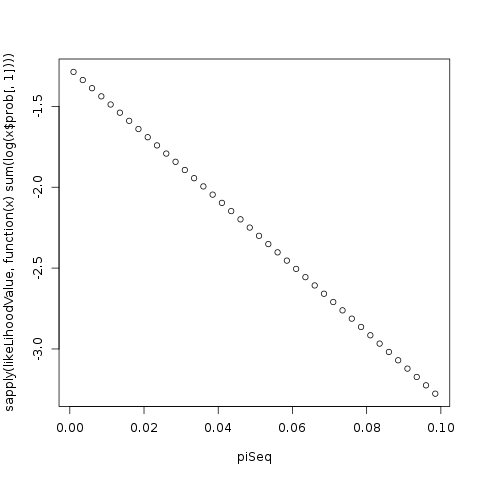

In [12]:
%%R
plot(piSeq, sapply(likeLihoodValue, function(x) sum(log(x$prob[, 1]))))

In [13]:
%%R
plot(piSeq, likeLihoodValue)


Error in xy.coords(x, y, xlabel, ylabel, log) : 
  (list) object cannot be coerced to type 'double'


//anaconda3/lib/python3.4/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in xy.coords(x, y, xlabel, ylabel, log) : 
  (list) object cannot be coerced to type 'double'

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [14]:
%%R
piSeq <- seq(0.005, 0.2, by = 0.005)

likeLihoodValue <- lapply(piSeq, function(x)
    marginal(hyperpar = hyperpar, pi = x, counts = counts, N = N, mu = data$mut*mu.frac[1])$marginal
    )

In [15]:
%%R
likeLihoodValue0 <- c(likeLihoodValue0, likeLihoodValue)


Error in withVisible({ : object 'likeLihoodValue0' not found


//anaconda3/lib/python3.4/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : object 'likeLihoodValue0' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [16]:
%%R
plot(1:length(likeLihoodValue0), as.numeric(likeLihoodValue0))

#plot(piSeq, as.numeric(likeLihoodValue))


Error in plot(1:length(likeLihoodValue0), as.numeric(likeLihoodValue0)) : 
  object 'likeLihoodValue0' not found


//anaconda3/lib/python3.4/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in plot(1:length(likeLihoodValue0), as.numeric(likeLihoodValue0)) : 
  object 'likeLihoodValue0' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [19]:
%%R
hyperpar

               [,1]   [,2]
gamma.mean.dn  20.0    4.7
beta.dn         1.0    1.0
gamma.mean.CC   2.3    1.0
beta.CC         4.0 1000.0
rho1            0.1    0.5
nu1           200.0  100.0
rho0            0.1    0.5
nu0           200.0  100.0


In [17]:
%%R
#Only de novo data
piSeq <- seq(0.01, 0.15, by = 0.015)

likeLihoodValueDN <- lapply(piSeq, function(pi_0)
    marginal(hyperpar = hyperpar, pi = pi_0, counts = counts, N = N, mu = data$mut*mu.frac[1],
            denovo.only = TRUE)$marginal
    )

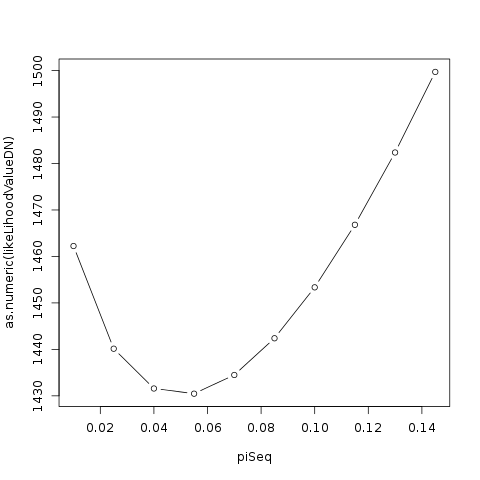

In [18]:
%%R
#plot(1:length(likeLihoodValueDN), as.numeric(likeLihoodValueDN))

plot(piSeq, as.numeric(likeLihoodValueDN), type = 'b')



In [81]:
%%R
#Only de novo data
piSeq <- seq(0.01, 0.12, by = 0.01)
gamma.dn.LoF.seq <- seq(10, 30, by = 0.25)
beta.dn.LoF.seq <- seq(0.5, 2.5, by = 0.25)


In [83]:
%%R

#k.vec <- seq(500, 1500, by = 10)

#beta.array <- seq(0.1, 5, by = 0.025)

hyperTemp <- hyperpar

temp.Likelihood <- function(x, y){
hyperTemp[1, 1] <- x
    return(list(gamma.dn.LoF.seq = x, pi0 = y,
                llk = marginal(hyperpar = hyperTemp, pi = y, counts = counts, N = N, mu = data$mut.rate*mu.frac[1],
            denovo.only = TRUE)$marginal
               ))
}

llkList <- mapply(temp.Likelihood, gamma.dn.LoF.seq, piSeq)
llkList <- as.data.frame(t(llkList))

In [85]:
%%R
nG <- length(gamma.dn.LoF.seq)
nPi <- length(piSeq)
nBeta <- length(beta.dn.LoF.seq)

matrixLLK <- matrix(0, ncol = 4, nrow = nBeta*nG*nPi)
indexI <- 1

dim(matrixLLK)

[1] 8748    4


In [86]:
%%R
for (ii in 1:nG){
    hyperTemp[1, 1] <- gamma.dn.LoF.seq[ii]
    
    for (jj in 1:nPi){
        for (kk in 1:nBeta){
            hyperTemp[2, 1] <- beta.dn.LoF.seq[kk]
        matrixLLK[indexI, 4] <- 
        marginal(hyperpar = hyperTemp, pi = piSeq[jj], counts = counts, N = N, mu = data$mut.rate*mu.frac[1],
            denovo.only = TRUE)$marginal
            
        matrixLLK[indexI, 2] <- piSeq[jj]

         matrixLLK[indexI, 1] <- gamma.dn.LoF.seq[ii]
   
            matrixLLK[indexI, 3] <- beta.dn.LoF.seq[kk]
        indexI <- indexI + 1
                }}
}

In [92]:
%%R
matrixLLK[, 4] <- -matrixLLK[, 4]
head(matrixLLK)

     [,1] [,2] [,3]      [,4]
[1,]   10 0.01 0.50 -1487.137
[2,]   10 0.01 0.75 -1488.947
[3,]   10 0.01 1.00 -1489.948
[4,]   10 0.01 1.25 -1490.585
[5,]   10 0.01 1.50 -1491.027
[6,]   10 0.01 1.75 -1491.351


In [93]:
%%R
head(matrixLLK[order(-matrixLLK[, 4]), ], 30)

       [,1] [,2] [,3]      [,4]
 [1,] 30.00 0.03 0.50 -1427.525
 [2,] 29.75 0.03 0.50 -1427.576
 [3,] 29.50 0.03 0.50 -1427.633
 [4,] 29.25 0.03 0.50 -1427.695
 [5,] 29.00 0.03 0.50 -1427.764
 [6,] 30.00 0.03 0.75 -1427.810
 [7,] 26.00 0.04 0.50 -1427.833
 [8,] 25.75 0.04 0.50 -1427.837
 [9,] 26.25 0.04 0.50 -1427.837
[10,] 28.75 0.03 0.50 -1427.839
[11,] 26.50 0.04 0.50 -1427.850
[12,] 25.50 0.04 0.50 -1427.850
[13,] 29.75 0.03 0.75 -1427.866
[14,] 26.75 0.04 0.50 -1427.870
[15,] 25.25 0.04 0.50 -1427.871
[16,] 27.00 0.04 0.50 -1427.898
[17,] 25.00 0.04 0.50 -1427.900
[18,] 28.50 0.03 0.50 -1427.920
[19,] 29.50 0.03 0.75 -1427.929
[20,] 27.25 0.04 0.50 -1427.934
[21,] 24.75 0.04 0.50 -1427.939
[22,] 30.00 0.03 1.00 -1427.965
[23,] 27.50 0.04 0.50 -1427.977
[24,] 24.50 0.04 0.50 -1427.987
[25,] 29.25 0.03 0.75 -1427.997
[26,] 28.25 0.03 0.50 -1428.007
[27,] 29.75 0.03 1.00 -1428.025
[28,] 27.75 0.04 0.50 -1428.028
[29,] 24.25 0.04 0.50 -1428.043
[30,] 30.00 0.03 1.25 -1428.064


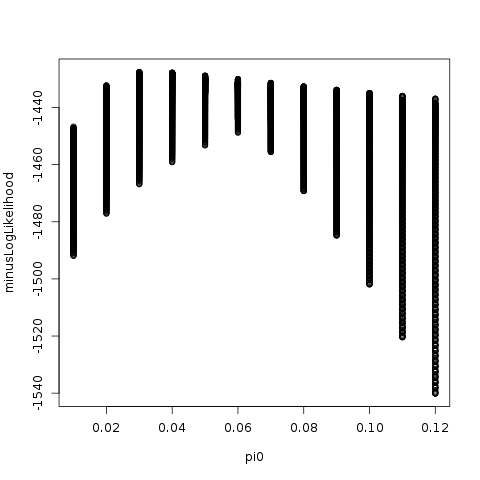

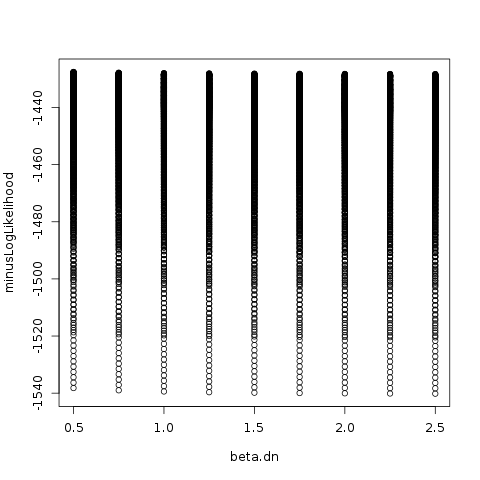

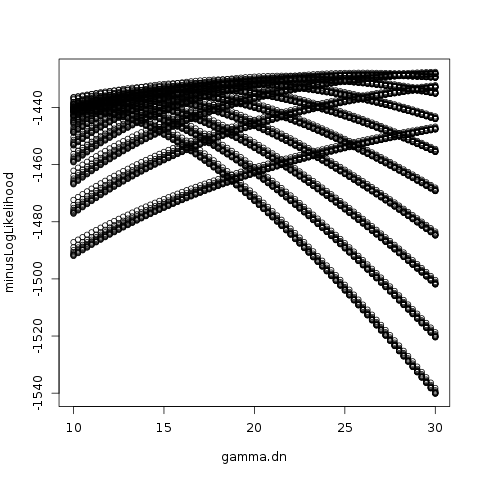

In [94]:
%%R
plot(matrixLLK[, 2], matrixLLK[, 4], xlab = 'pi0', ylab = 'minusLogLikelihood')
plot(matrixLLK[, 3], matrixLLK[, 4], xlab = 'beta.dn', ylab = 'minusLogLikelihood')
plot(matrixLLK[, 1], matrixLLK[, 4], xlab = 'gamma.dn', ylab = 'minusLogLikelihood')

In [96]:
%%R
library("dplyr")

//anaconda3/lib/python3.4/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: 'dplyr'


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda3/lib/python3.4/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from 'package:stats':

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda3/lib/python3.4/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [98]:
%%R
matrixLLK <- dplyr::tbl_df(as.data.frame(matrixLLK))

In [ ]:
%%R

system.time(llk0 <- apply(matrixLLK, 1, function(x){
    
     hyperTemp[1:2, 1] <- x[1:2]
    
        outLLK <- marginal(hyperpar = hyperTemp, pi = x[3], 
                           counts = counts, N = N, mu = data$mut.rate*mu.frac[1],
                           denovo.only = TRUE)$marginal
    return(outLLK)
            
}))

In [48]:
%%R
llkList <- apply(llkList, 2, as.numeric)

In [52]:
%%R
tempA <- cbind(llkList[, 1], llkList[, 2], llkList[, 3])
tempA <- tempA[order(-tempA[, 3]), ]
tempA

       [,1]  [,2]     [,3]
 [1,] 10.00 0.010 1489.948
 [2,] 11.75 0.010 1483.678
 [3,] 13.50 0.010 1478.126
 [4,] 15.25 0.010 1473.187
 [5,] 23.75 0.100 1469.066
 [6,] 17.00 0.010 1468.776
 [7,] 10.25 0.025 1468.489
 [8,] 18.75 0.010 1464.823
 [9,] 12.00 0.025 1461.340
[10,] 22.00 0.100 1461.299
[11,] 20.50 0.010 1461.271
[12,] 22.25 0.010 1458.073
[13,] 13.75 0.025 1455.272
[14,] 24.00 0.010 1455.190
[15,] 10.50 0.040 1454.958
[16,] 20.25 0.100 1454.287
[17,] 23.50 0.085 1452.076
[18,] 15.50 0.025 1450.114
[19,] 18.50 0.100 1448.174
[20,] 12.25 0.040 1448.147
[21,] 21.75 0.085 1446.861
[22,] 10.75 0.055 1445.913
[23,] 17.25 0.025 1445.728
[24,] 16.75 0.100 1443.145
[25,] 14.00 0.040 1442.693
[26,] 25.00 0.070 1442.595
[27,] 20.00 0.085 1442.393
[28,] 19.00 0.025 1442.009
[29,] 11.00 0.070 1440.260
[30,] 12.50 0.055 1440.170
[31,] 15.00 0.100 1439.428
[32,] 23.25 0.070 1439.156
[33,] 20.75 0.025 1438.867
[34,] 18.25 0.085 1438.810
[35,] 15.75 0.040 1438.372
[36,] 11.25 0.085 1437.462
[

In [51]:
%%R
split(tempA, tempA[, 1])

$`10`
[1]   10.000    0.010 1489.948

$`10.25`
[1]   10.250    0.025 1468.489

$`10.5`
[1]   10.500    0.040 1454.958

$`10.75`
[1]   10.750    0.055 1445.913

$`11`
[1]   11.00    0.07 1440.26

$`11.25`
[1]   11.250    0.085 1437.462

$`11.5`
[1]   11.500    0.100 1437.192

$`11.75`
[1]   11.750    0.010 1483.678

$`12`
[1]   12.000    0.025 1461.340

$`12.25`
[1]   12.250    0.040 1448.147

$`12.5`
[1]   12.500    0.055 1440.170

$`12.75`
[1]   12.750    0.070 1436.108

$`13`
[1]   13.000    0.085 1435.294

$`13.25`
[1]   13.250    0.100 1437.316

$`13.5`
[1]   13.500    0.010 1478.126

$`13.75`
[1]   13.750    0.025 1455.272

$`14`
[1]   14.000    0.040 1442.693

$`14.25`
[1]   14.250    0.055 1436.008

$`14.5`
[1]   14.500    0.070 1433.713

$`14.75`
[1]   14.750    0.085 1435.018

$`15`
[1]   15.000    0.100 1439.428

$`15.25`
[1]   15.250    0.010 1473.187

$`15.5`
[1]   15.500    0.025 1450.114

$`15.75`
[1]   15.750    0.040 1438.372

$`16`
[1]   16.000    0.055 1433.152

$`16.

In [20]:
%%R
marginal


function(hyperpar, pi, counts, N, mu, prior.weight=0, denovo.only=FALSE, debug=FALSE) {
  gamma.mean.dn <- hyperpar[1]
  beta.dn <- hyperpar[2]
  gamma.mean.CC <- hyperpar[3]
  beta.CC <- hyperpar[4]
  rho1 <- hyperpar[5]
  nu1 <- hyperpar[6]
  rho0 <- hyperpar[7]
  nu0 <- hyperpar[8]

  n <- nrow(counts)
  prob <- numeric(n)
  posterior <- numeric(n)
  bf <- numeric(n)
  for (i in 1:n)  {
    if (debug) cat("i = ", i, "\tdn = ", counts[i,]$dn, "\tca = ", counts[i,]$ca, "\tcn = ", counts[i,]$cn, "\n")
    if (denovo.only==TRUE) {
      prob.M1 <- evidence.alt.dn(counts[i,"dn"], N$dn, mu[i], gamma.mean.dn, beta.dn)
      prob.M0 <- evidence.null.dn(counts[i,"dn"], N$dn, mu[i])
    } else {
      prob.M1 <-  evidence.alt(counts[i,],N,mu[i],gamma.mean.dn, beta.dn, gamma.mean.CC, beta.CC, rho1, nu1)
      prob.M0 <-  evidence.null(counts[i,],N,mu[i],rho0, nu0)
    }
    if (debug) cat("prob.M1 = ", prob.M1,"\n")
    if (debug) cat("Prob.M0 = ", prob.M0, "\n")
    prob[i] <- pi * prob.M1 + 

In [21]:
%%R
evidence.alt.CC

function(x, N, gamma.mean, beta, rho1, nu1, q.lower=1e-8, q.upper=0.1, debug=FALSE) {
  integrand <- function(u) {
    q <- exp(u)
    return (dnbinom(x$ca, gamma.mean*beta, beta/(beta+N$ca*q)) * dgamma(q, rho1+x$cn, nu1+N$cn) * exp(u))
  }

  marglik1.ctrl <- dnbinom(x$cn, rho1, nu1/(nu1+N$cn))
  marglik1.case <- integrate(integrand, lower=log(q.lower), upper=log(q.upper))$value

  marglik1 <- marglik1.ctrl * marglik1.case

  #   return (exp(marglik1.ctrl.log+marglik1.case.log))
  return (list(ctrl=marglik1.ctrl, case=marglik1.case, total=marglik1))
}


In [22]:
%%R
evidence.alt

function(x, N, mu,
                         gamma.mean.dn, beta.dn,
                         gamma.mean.CC, beta.CC,
                         rho1, nu1){

    k <- length(mu) ##Mutation rate of the gene

    x <- as.numeric(x)

    prob.gene.CC <- rep(1, k)

    prob.gene.dn <- rep(1, k)

    gamma.mean.dn <- gamma.mean.dn
    beta.dn <- beta.dn

    gamma.mean.CC <- gamma.mean.CC
    beta.CC <- beta.CC

  # Compute BFs: BF[i,j] is the BF of the i-th gene in the j-th category

###Calculate probability for case-control counts
    for (j in 1:k){
             # model evidence of case-control data: P(x_1,x_0|H_1)
# Input: the count data x, the sample size N and the parameters
# Prior distribution of RR: gamma ~ Gamma(gamma.mean*beta, beta)
# Prior distribution of q|H1: Gamma(rho1, nu1)

             start <- 3*(j - 1) + 1
             xCC <- c(start + 1, start + 2)
             names(xCC) <- c("ca", "cn")

             xI <- list(dn = x[start], ca = x[start + 1], cn = x[start + 2])

     

In [12]:
%%R
empBayes

function(counts, N, mu, hyperpar.init, pi.init, lower, upper, lower.pi=1e-10, upper.pi=1, est.option=rep(FALSE, 8), est.pi=FALSE, prior.weight=0, debug=FALSE) {  
  # marginal likelihood function (parameters in log-scale)
  marginal.loglike <- function(subpar.log) {
    subpar <- exp(subpar.log)
    allpar <- subpar2fullpar(subpar, hyperpar.init, pi.init, est.option, est.pi)
    hyperpar <- allpar$hyperpar
    pi <- allpar$pi
    result <- marginal(hyperpar,  pi, counts, N, mu, prior.weight=prior.weight)$marginal  
    
    if (debug) {
      cat("Parameters = (", paste(subpar, collapse=", "), ")\tValue = ", result, "\n", sep="") 
    }
    
    return (result)
  }
  
  # no parameter to estimate
  if ( sum(est.option==TRUE) == 0 & est.pi == FALSE ) {
    value <- marginal(hyperpar.init, pi.init, counts, N, mu, prior.weight=prior.weight)$marginal
    return (list(hyperpar=hyperpar.init, value=value))
  }
  
  # initialize the sub. parameters
  subpar.init <- fullpar2subpar(hyperpar.ini

In [56]:
#!gist -p Check_emBayes_TADA.ipynb

https://gist.github.com/865fd03bdf6bbb6ec0c6


In [95]:
!gist -u https://gist.github.com/865fd03bdf6bbb6ec0c6 Check_emBayes_TADA.ipynb

/bin/sh: 1: gist: not found
